# BÀI THỰC HÀNH 3: MẠNG NEURAL HỒI QUY CHO BÀI TOÁN PHÂN LOẠI VĂN BẢN VÀ GÁN NHÃN CHUỖI

<b>Hướng dẫn nộp bài:</b> Các bạn commit và push code lên github, sử dụng file txt đặt tên theo cú pháp <MSSV>.txt chứa đường link dẫn đến github của bài thực hành và nộp file txt này tên courses.

Bộ dữ liệu sử dụng: [UIT-VSFC](https://drive.google.com/drive/folders/1rdcXNGt_3-QUvV8EtSvVsLMVeHmk6Yqk?usp=drive_link) và [PhoNERT](https://github.com/VinAIResearch/PhoNER_COVID19).

# Import libraries

In [62]:
import pandas as pd
import numpy as np
import json
import re
from underthesea import word_tokenize
import emoji
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# EDA

## BỘ DỮ LIỆU UIT-VSFC (Phân loại văn bản)

1. Kiểm tra cấu trúc bộ dữ liệu

* Tải và đọc các file .txt hoặc .csv từ UIT-VSFC.

* Kiểm tra các cột có trong dataset (ví dụ: sentence, label).

* Kiểm tra số lượng mẫu train/valid/test.

* Lấy 10 mẫu đầu tiên để xem dữ liệu thực trông như thế nào.

In [63]:
# Load dataset
files = ['train.json', 'dev.json', 'test.json']
fnames = ['train', 'dev', 'test']
dataset = {}

for name, file in zip(fnames, files):
    with open(f"data/UIT-VSFC/UIT-VSFC-{file}", "r", encoding="utf-8") as f:
        data = json.load(f)
    dataset[name] = pd.DataFrame(data)

train = dataset['train']
dev = dataset['dev']
test = dataset['test']

In [64]:
# Print column names
print(f'Train colummns: {train.columns}')
print(f'Dev colummns: {dev.columns}')
print(f'Test colummns: {test.columns}')

Train colummns: Index(['sentence', 'sentiment', 'topic'], dtype='object')
Dev colummns: Index(['sentence', 'sentiment', 'topic'], dtype='object')
Test colummns: Index(['sentence', 'sentiment', 'topic'], dtype='object')


In [65]:
# Print dataset samples
print (f'Train samples: {train.shape[0]}')
print (f'Dev samples: {dev.shape[0]}')   
print (f'Test samples: {test.shape[0]}')

Train samples: 11426
Dev samples: 1583
Test samples: 3166


In [66]:
# Print first 10 rows of the training set
train.head(10)

,sentence,sentiment,topic
0,slide giáo trình đầy đủ .,positive,training_program
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",positive,lecturer
2,đi học đầy đủ full điểm chuyên cần .,negative,training_program
3,chưa áp dụng công nghệ thông tin và các thiết ...,negative,lecturer
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",positive,lecturer
5,"giảng viên đảm bảo thời gian lên lớp , tích cự...",positive,lecturer
6,"em sẽ nợ môn này , nhưng em sẽ học lại ở các h...",neutral,others
7,"thời lượng học quá dài , không đảm bảo tiếp th...",negative,training_program
8,"nội dung môn học có phần thiếu trọng tâm , hầu...",negative,training_program
9,cần nói rõ hơn bằng cách trình bày lên bảng th...,negative,training_program


In [67]:
# Print first 10 rows of the development set
dev.head(10)

,sentence,sentiment,topic
0,giáo trình chưa cụ thể .,negative,training_program
1,giảng buồn ngủ .,negative,lecturer
2,"giáo viên vui tính , tận tâm .",positive,lecturer
3,"giảng viên nên giao bài tập nhiều hơn , chia n...",negative,lecturer
4,"giảng viên cần giảng bài chi tiết hơn , đi sâu...",negative,lecturer
5,nên có giảng viên nước ngoài dạy để sinh viên ...,negative,lecturer
6,nên có bài tập lớn đồ án môn học .,negative,training_program
7,"giảng viên đảm bảo nội dung học , phân tích gi...",positive,lecturer
8,"nêu rõ mục tiêu , mục đích môn học để sinh viê...",negative,training_program
9,có một số vấn đề nói chưa rõ .,negative,training_program


In [68]:
# Print first 10 rows of the test set
test.head(10)

,sentence,sentiment,topic
0,nói tiếng anh lưu loát .,positive,lecturer
1,giáo viên rất vui tính .,positive,lecturer
2,cô max có tâm .,positive,lecturer
3,"giảng bài thu hút , dí dỏm .",positive,lecturer
4,"giáo viên không giảng dạy kiến thức , hướng dẫ...",negative,lecturer
5,thầy dạy nhiệt tình và tâm huyết .,positive,lecturer
6,tính điểm thi đua các nhóm .,positive,training_program
7,thầy nhiệt tình giảng lại cho học sinh .,positive,lecturer
8,có đôi lúc nói hơi nhanh làm sinh viên không t...,negative,lecturer
9,"giảng dạy nhiệt tình , liên hệ thực tế khá nhi...",positive,lecturer


2. Phân tích phân bố nhãn (Label Distribution)

* Thống kê tần suất mỗi nhãn (Positive / Negative / Neutral).

* Vẽ biểu đồ (bar chart) phân bố nhãn.

* **Trả lời câu hỏi**: Bộ dữ liệu có bị mất cân bằng nhãn không?

Sentiment distribution:
           Train  Dev  Test
sentiment                  
positive    5643  805  1590
negative    5325  705  1409
neutral      458   73   167


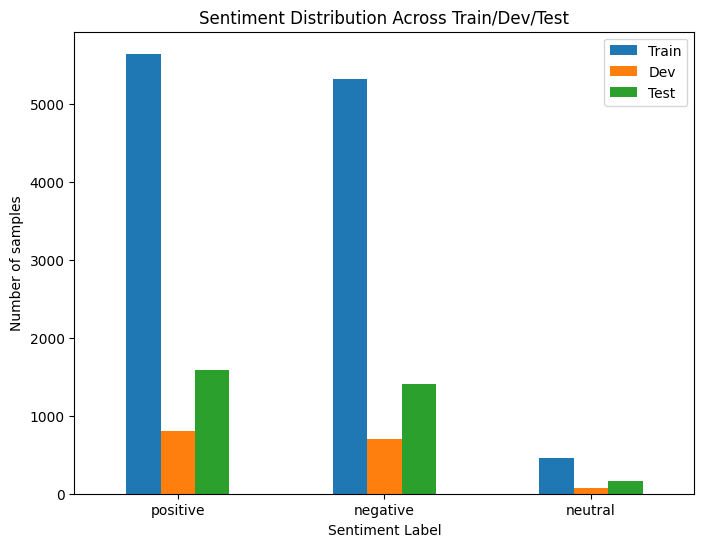

In [69]:
# Compare sentiment distributions across train, dev, and test sets
label_counts = pd.DataFrame({
    "Train": train['sentiment'].value_counts(),
    "Dev": dev['sentiment'].value_counts(),
    "Test": test['sentiment'].value_counts()
})
print(f'Sentiment distribution:\n{label_counts}')

# Visualize combined sentiment distribution
label_counts.plot(kind='bar', figsize=(8, 6))
plt.title("Sentiment Distribution Across Train/Dev/Test")
plt.ylabel("Number of samples")
plt.xlabel("Sentiment Label")
plt.xticks(rotation=0)
plt.show()

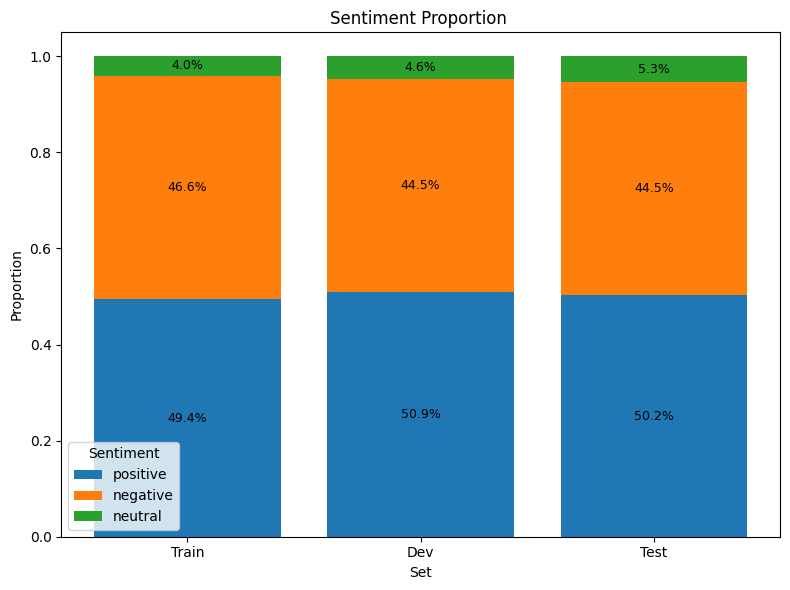

In [70]:
# Visualize sentiment proportions
label_props = label_counts.div(label_counts.sum(axis=0), axis=1)
fig, ax = plt.subplots(figsize=(8, 6))
bottom = [0] * len(label_props.columns)

for sentiment, color in zip(label_props.index, ['#1f77b4', '#ff7f0e', '#2ca02c']):
    values = label_props.loc[sentiment]
    bars = ax.bar(label_props.columns, values, bottom=bottom, label=sentiment, color=color)
    
    for j, bar in enumerate(bars):
        h = bar.get_height()
        if h > 0.01:
            ax.text(bar.get_x() + bar.get_width()/2, bottom[j] + h/2, f"{h*100:.1f}%", 
                    ha='center', va='center', fontsize=9)
        bottom[j] += h

ax.set(title="Sentiment Proportion ", ylabel="Proportion", xlabel="Set")
ax.set_ylim(0, 1.05)
ax.legend(title="Sentiment")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

* Positive và Negative chiếm phần lớn số lượng mẫu (trên 95%) trong cả ba tập (Train, Dev, Test).

* Neutral là nhãn thiểu số chỉ chiếm từ 4-5%, có thể gây khó khăn cho mô hình khi học và phân loại đúng.

-> Bộ dữ liệu có dấu hiệu mất cân bằng nghiêm trọng với nhãn Neutral. Có thể sử dụng các phương pháp xử lý mất cân bằng nhãn nếu cần thiết.

3. Phân tích độ dài câu

* Tính số token/word trong từng câu.

* Vẽ histogram hoặc boxplot độ dài câu.

Tìm: Max sequence length hợp lý khi padding (ví dụ: 50, 100, 200).

In [71]:
# Count token/word in each sentence
train_lengths = train['sentence'].apply(lambda x: len(x.split()))
dev_lengths = dev['sentence'].apply(lambda x: len(x.split()))
test_lengths = test['sentence'].apply(lambda x: len(x.split()))

# Print sentences length statistics
print(f'Train sentence lengths:\n{train_lengths.describe()}\n')
print(f'Dev sentence lengths:\n{dev_lengths.describe()}\n')
print(f'Test sentence lengths:\n{test_lengths.describe()}\n')

Train sentence lengths:
count    11426.000000
mean        14.308769
std         10.089727
min          2.000000
25%          8.000000
50%         11.000000
75%         17.000000
max        159.000000
Name: sentence, dtype: float64

Dev sentence lengths:
count    1583.000000
mean       13.671510
std         9.912805
min         2.000000
25%         8.000000
50%        11.000000
75%        17.000000
max       161.000000
Name: sentence, dtype: float64

Test sentence lengths:
count    3166.000000
mean       14.220783
std        10.242381
min         2.000000
25%         8.000000
50%        11.000000
75%        17.000000
max        98.000000
Name: sentence, dtype: float64



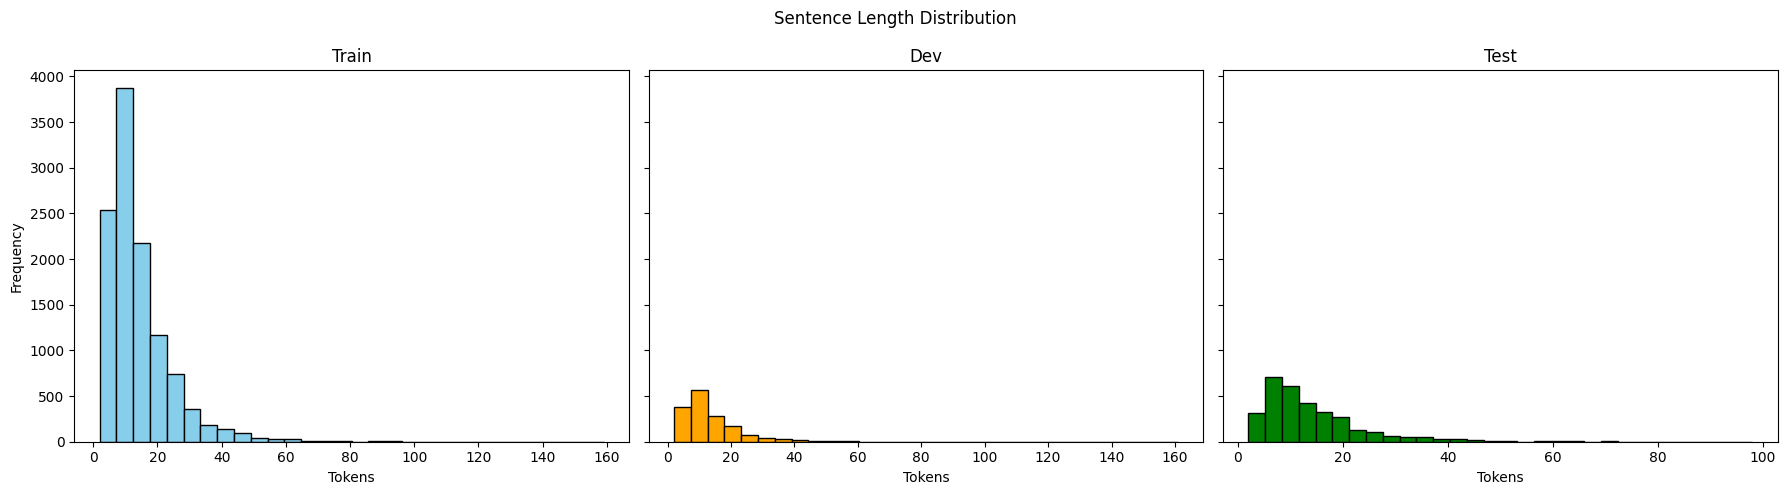

In [72]:
# Plot sentence length distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Train
axes[0].hist(train_lengths, bins=30, color='skyblue', edgecolor='black')
axes[0].set_title("Train")
axes[0].set_xlabel("Tokens")
axes[0].set_ylabel("Frequency")

# Dev
axes[1].hist(dev_lengths, bins=30, color='orange', edgecolor='black')
axes[1].set_title("Dev")
axes[1].set_xlabel("Tokens")

# Test
axes[2].hist(test_lengths, bins=30, color='green', edgecolor='black')
axes[2].set_title("Test")
axes[2].set_xlabel("Tokens")

plt.suptitle("Sentence Length Distribution")
plt.tight_layout()
plt.show()


In [73]:
optimal_pad = int(np.percentile(train_lengths, 98))
print("Padding (98%):", optimal_pad)

Padding (98%): 44


* Train: phần lớn câu nằm dưới 80 tokens, nhưng có đuôi kéo dài tới ~160.

* Dev: hầu hết câu dưới 50 tokens, rất ít câu dài hơn 60.

* Test: phân bố giống train, nhưng nhẹ hơn — đa số dưới 80, một số lên tới gần 100.

-> Chọn max_sequence_length = 50 để bao phủ >98% câu ở cả 3 tập và giữ thêm thông tin cho các câu dài. 

4. Thống kê từ vựng

* Đếm số lượng từ vựng (unique tokens).

* Top 20 từ xuất hiện nhiều nhất.

* Trả lời câu hỏi: Có cần làm preprocessing không? (lowercase, remove punctuation, fix unicode…)

In [74]:
# Unique token
def unique_tokens(dataset):
    token_counter = Counter()
    for sentence in dataset:
        tokens = sentence.split()
        token_counter.update(tokens)
    return token_counter

train_token_counts = unique_tokens(train['sentence'])
dev_token_counts = unique_tokens(dev['sentence'])
test_token_counts = unique_tokens(test['sentence'])

In [75]:
# Count unique tokens in each dataset
print(f'Number of unique tokens in the train set: {len(train_token_counts)}')
print(f'Number of unique tokens in the dev set: {len(dev_token_counts)}')
print(f'Number of unique tokens in the test set: {len(test_token_counts)}')

Number of unique tokens in the train set: 2514
Number of unique tokens in the dev set: 1157
Number of unique tokens in the test set: 1581


In [76]:
# Display the most 20 tokens
print(f'Most common tokens in Train set:\n{train_token_counts.most_common(20)}')
print(f'Most common tokens in Dev set:\n{dev_token_counts.most_common(20)}')
print(f'Most common tokens in Test set:\n{test_token_counts.most_common(20)}')

Most common tokens in Train set:
[('.', 11009), (',', 6827), ('viên', 4803), ('giảng', 3711), ('dạy', 3156), ('thầy', 3095), ('sinh', 3082), ('học', 2940), ('bài', 2336), ('tình', 2266), ('không', 2177), ('và', 2068), ('có', 2031), ('rất', 1961), ('nhiệt', 1931), ('cho', 1735), ('hiểu', 1730), ('nhiều', 1622), ('tập', 1454), ('dễ', 1438)]
Most common tokens in Dev set:
[('.', 1528), (',', 948), ('viên', 644), ('giảng', 543), ('dạy', 459), ('thầy', 415), ('sinh', 400), ('học', 366), ('bài', 328), ('tình', 321), ('nhiệt', 282), ('rất', 280), ('không', 271), ('và', 270), ('có', 257), ('hiểu', 238), ('cho', 238), ('nhiều', 235), ('thực', 206), ('dễ', 199)]
Most common tokens in Test set:
[('.', 3064), (',', 1890), ('viên', 1253), ('giảng', 985), ('dạy', 908), ('thầy', 899), ('học', 808), ('sinh', 796), ('không', 648), ('bài', 645), ('tình', 624), ('và', 566), ('rất', 560), ('nhiệt', 548), ('có', 516), ('hiểu', 459), ('cho', 443), ('nhiều', 426), ('dễ', 403), ('tập', 391)]


Dữ liệu nên được tiền xử lý trước khi huấn luyện mô hình: 

* Lowercase giúp giảm số lượng từ vựng trùng lặp do viết hoa/viết thường.

* Remove punctuation để loại bỏ dấu câu như ".", "," không mang nhiều ý nghĩa trong mô hình.

* Fix Unicode nếu dữ liệu có lỗi mã hóa (ký tự lạ, dấu sai…).

-> Tiền xử lý dữ liệu văn bản là bước quan trọng giúp làm sạch, chuẩn hóa dữ liệu, giúp giảm số lượng từ vựng trùng lặp, tăng độ nhất quán, và loại bỏ nhiễu không cần thiết. Nhờ đó, mô hình học hiệu quả hơn, tốc độ huấn luyện nhanh hơn, và kết quả phân tích chính xác hơn.

5. Tiền xử lý dữ liệu

* Sinh viên phải mô tả:

* Các bước preprocessing sẽ áp dụng cho text: chuẩn hóa unicode, tách từ (tokenization dùng VnCoreNLP / underthesea / pyvi…), lowercasing, xử lý emoji, loại bỏ ký tự thừa, ...

Minh hoạ bằng ví dụ before → after.

In [77]:
# Load Vietnamese stopwords
with open("vietnamese-stopwords.txt", "r", encoding="utf-8") as f:
    VIETNAMESE_STOPWORDS = set(f.read().splitlines())

def preprocess_vietnamese(text):

    # Normalization of unicode while preserving diacritics
    text = unicodedata.normalize('NFC', text)

    # Convert to lowercase
    text = text.lower()

    # Handle emojis (convert to text)
    text = emoji.demojize(text)

    # Remove special characters, keep only letters and numbers
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize using underthesea
    tokens = word_tokenize(text, format="text")

    # Remove stopwords
    tokens = [tok for tok in tokens if tok not in VIETNAMESE_STOPWORDS]

    return tokens

In [78]:
# Get 5 random sample sentences from the training set
sample_sentences = train['sentence'].sample(5, random_state=42)

# Preprocess and display results
for sample in sample_sentences:
    processed = preprocess_vietnamese(sample)
    print("Before:", sample, "-> After :", processed)

Before: có khả năng truyền đạt tốt . -> After : ['c', 'ó', ' ', 'k', 'h', 'ả', '_', 'n', 'ă', 'n', 'g', ' ', 't', 'r', 'u', 'y', 'ề', 'n', '_', 'đ', 't', ' ', 't', 'ố', 't']
Before: khi có nhóm lên seminar thì phải có ít nhất ba câu hỏi thì mới " đậu " , không cần biết câu hỏi là gì , không đủ ba câu thì phải làm lại . -> After : ['k', 'h', 'i', ' ', 'c', 'ó', ' ', 'n', 'h', 'ó', 'm', ' ', 'l', 'ê', 'n', ' ', 's', 'e', 'm', 'i', 'n', 'a', 'r', ' ', 't', 'h', 'ì', ' ', 'p', 'h', 'ả', 'i', ' ', 'c', 'ó', ' ', 'í', 't', '_', 'n', 'h', 'ấ', 't', ' ', 'b', 'a', ' ', 'c', 'â', 'u', ' ', 'h', 'ỏ', 'i', ' ', 't', 'h', 'ì', ' ', 'm', 'i', ' ', 'đ', 'ậ', 'u', ' ', 'k', 'h', 'ô', 'n', 'g', ' ', 'c', 'ầ', 'n', ' ', 'b', 'i', 'ế', 't', ' ', 'c', 'â', 'u', ' ', 'h', 'ỏ', 'i', ' ', 'l', ' ', 'g', 'ì', ' ', 'k', 'h', 'ô', 'n', 'g', ' ', 'đ', 'ủ', ' ', 'b', 'a', ' ', 'c', 'â', 'u', ' ', 't', 'h', 'ì', ' ', 'p', 'h', 'ả', 'i', ' ', 'l', 'm', ' ', 'l', 'i']
Before: thầy giảng buồn ngủ , không nhiệt tình 

### Bài 1: Xây dựng mạng LSTM gồm 5 lớp với hidden size là 256 cho bài toán phân loại văn bản. Huấn luyện mô hình này trên bộ dữ liệu UIT-VSFC (Vietnamese Student Feedback Corpus) sử dụng Adam làm phương thức tối ưu tham số và đánh giá độ hiệu quả của mô hình sử dụng độ đo F1.

In [79]:
import pandas as pd
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from gensim.models import KeyedVectors
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
import os

# Define hyperparameters
HIDDEN_SIZE = 256
VOCAB_SIZE = 20000        
EMBEDDING_DIM = 100       
NUM_CLASSES = 3           
DROPOUT_RATE = 0.3
MAX_LEN = 50
EPOCHS = 5
BATCH_SIZE = 64

In [80]:
# Preprocess the datasets
train['sentence'] = train['sentence'].apply(preprocess_vietnamese)
dev['sentence'] = dev['sentence'].apply(preprocess_vietnamese)
test['sentence'] = test['sentence'].apply(preprocess_vietnamese)

# Prepare input data
X_train = train['sentence'].tolist()
X_dev = dev['sentence'].tolist()
X_test = test['sentence'].tolist()

# Tokenization
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>") 
tokenizer.fit_on_texts(X_train)

# Sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
dev_sequences = tokenizer.texts_to_sequences(X_dev)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
X_train_padded = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
X_dev_padded = pad_sequences(dev_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_padded = pad_sequences(test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

In [81]:
# Labels
y_train = train['sentiment'].tolist()
y_dev = dev['sentiment'].tolist()
y_test = test['sentiment'].tolist()

# Label Encoding
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_dev = le.transform(y_dev)
y_test = le.transform(y_test)

In [82]:
print(f"Shape of X_train after padding: {X_train_padded.shape}")
print(f"Shape of y_train after padding: {y_train.shape}")

Shape of X_train after padding: (11426, 50)
Shape of y_train after padding: (11426,)


In [83]:
model = Sequential([
    # Layer 1: Embedding
    Embedding(input_dim=VOCAB_SIZE, 
              output_dim=EMBEDDING_DIM, 
              input_length=MAX_LEN,
              name='Embedding_Layer'),
    
    # Layer 2
    LSTM(HIDDEN_SIZE, return_sequences=True, dropout=DROPOUT_RATE, name='LSTM_Layer_1'),
    # Layer 3
    LSTM(HIDDEN_SIZE, return_sequences=True, dropout=DROPOUT_RATE, name='LSTM_Layer_2'),
    # Layer 4
    LSTM(HIDDEN_SIZE, return_sequences=True, dropout=DROPOUT_RATE, name='LSTM_Layer_3'),
    # Layer 5
    LSTM(HIDDEN_SIZE, return_sequences=True, dropout=DROPOUT_RATE, name='LSTM_Layer_4'),
    # Layer 6
    LSTM(HIDDEN_SIZE, dropout=DROPOUT_RATE, name='LSTM_Layer_5'),
    
    # Layer 7: Dense/Output
    Dense(NUM_CLASSES, activation='softmax', name='Output_Layer')
])

model.summary()

c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Embedding_Layer (Embedding)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Layer_1 (LSTM)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Layer_2 (LSTM)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Layer_3 (LSTM)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Layer_4 (LSTM)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Layer_5 (LSTM)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [84]:
class F1ScoreCallback(Callback):
    def __init__(self, validation_data, average='macro', save_path="best_model.keras"):
        super().__init__()
        self.X_val, self.y_val = validation_data
        self.average = average
        self.best_f1 = 0.0
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        y_pred_proba = self.model.predict(self.X_val, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)
        
        f1 = f1_score(self.y_val, y_pred, average=self.average)
        logs['val_f1_score'] = f1
        
        if f1 > self.best_f1:
            self.best_f1 = f1
            self.model.save(self.save_path)

In [85]:
# Calculate class weights to handle class imbalance
unique, counts = np.unique(y_train, return_counts=True)

N = len(y_train)
K = len(unique)

class_weights = {int(cls): N / (K * int(cnt)) for cls, cnt in zip(unique, counts)}

class_weights_named = {
    le.inverse_transform([cls])[0]: weight
    for cls, weight in class_weights.items()
}

print("Class weights:", class_weights_named)


Class weights: {'negative': 0.7152425665101722, 'neutral': 8.315866084425036, 'positive': 0.674936499497903}


In [86]:
# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Initialize F1 Score Callback
f1_callback = F1ScoreCallback(validation_data=(X_dev_padded, y_dev), average="macro", save_path="best_model_lstm.keras")

# Train the model with class weights to handle label imbalance

history = model.fit(
    X_train_padded, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_dev_padded, y_dev),
    callbacks=[f1_callback],
    verbose=1,
    class_weight=class_weights # Added class weights
)

Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 143s 703ms/step - accuracy: 0.4326 - loss: 1.0302 - val_accuracy: 0.3304 - val_loss: 1.0737 - val_f1_score: 0.2444
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 131s 730ms/step - accuracy: 0.5466 - loss: 0.9322 - val_accuracy: 0.6898 - val_loss: 0.7844 - val_f1_score: 0.4703
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 124s 692ms/step - accuracy: 0.6034 - loss: 0.8716 - val_accuracy: 0.6475 - val_loss: 0.8057 - val_f1_score: 0.5262
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 115s 643ms/step - accuracy: 0.6357 - loss: 0.8593 - val_accuracy: 0.6128 - val_loss: 0.8251 - val_f1_score: 0.5211
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 115s 643ms/step - accuracy: 0.6423 - loss: 0.8166 - val_accuracy: 0.6696 - val_loss: 0.6881 - val_f1_score: 0.5553


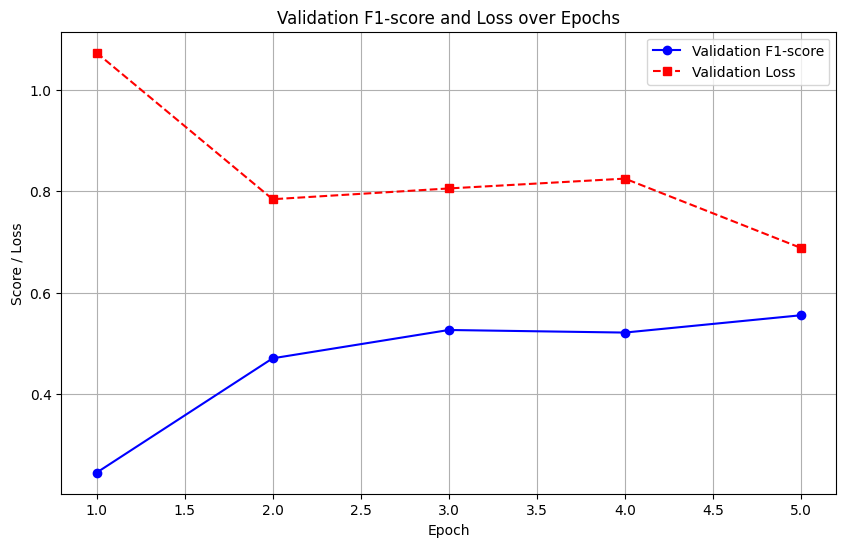

In [87]:
# Plot F1-score and Loss over epochs
f1_scores = history.history['val_f1_score']
val_losses = history.history['val_loss']
epochs = range(1, len(f1_scores) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, f1_scores, marker='o', linestyle='-', color='b', label='Validation F1-score')
plt.plot(epochs, val_losses, marker='s', linestyle='--', color='r', label='Validation Loss')
plt.title('Validation F1-score and Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score / Loss')
plt.legend()
plt.grid(True)
plt.show()

* Validation F1-score (xanh) tăng đều từ epoch 1 đến 3, sau đó giảm nhẹ ở epoch 4 rồi tăng lại ở epoch 5, cho thấy mô hình đang cải thiện nhưng có thể bị ảnh hưởng ngẫu nhiên trong quá trình huấn luyện.

* Validation Loss (đỏ) giảm mạnh ở từ epoch 1 sang epoch 2, sau đó tăng nhẹ ở epoch 3 – 4 rồi giảm tiếp ở epoch 5, có thể do mô hình đang điều chỉnh trọng số hoặc gặp khó khăn với một số mẫu.

-> Mô hình đang học ổn định với F1-score tăng đều và loss tăng nhẹ rồi tiếp tục giảm, dao động nhẹ giữa các epoch là bình thường với dữ liệu phức tạp. Có thể tiếp tục huấn luyện với 10 - 20 epoch, khi đó nên cân nhắc sử dụng EarlyStopping theo F1 để dừng khi không cải thiện, áp dụng ReduceLROnPlateau nếu loss chững lại.

In [88]:
# Load the best model
y_test_pred_proba = model.predict(X_test_padded)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

# Evaluate F1-Score and Classification Report
lstm_f1 = f1_score(y_test, y_test_pred, average='macro')

print(f"\nF1-Score: {lstm_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step

F1-Score: 0.5488

Classification Report:
              precision    recall  f1-score   support

    negative       0.67      0.72      0.69      1409
     neutral       0.14      0.45      0.21       167
    positive       0.90      0.63      0.74      1590

    accuracy                           0.66      3166
   macro avg       0.57      0.60      0.55      3166
weighted avg       0.76      0.66      0.69      3166



* Positive: F1-score cao nhất 0.74, precision đạt 0.90, mô hình nhận diện cảm xúc tích cực khá tốt.

* Negative: F1-score 0.69, recall 0.72, mô hình cũng xử lý khá ổn với cảm xúc tiêu cực.

* Neutral: F1-score rất thấp 0.21, precision chỉ 0.14. Mô hình gặp khó khăn lớn với cảm xúc trung lập, có thể do biểu hiện không rõ ràng hoặc số lượng mẫu ít chỉ 167.

-> F1-score trung bình ~ 0.55 (macro), mô hình có hiệu quả ở mức trung bình, cảm xúc trung lập thường mơ hồ, dễ bị nhầm với tiêu cực hoặc tích cực mặc dù đã áp dụng class_weights để giảm ảnh hưởng của mất cân bằng. Có thể xem xét tăng dữ liệu cho lớp neutral để mô hình học được đặc trưng rõ hơn. 

### Bài 2: Xây dựng mạng GRU gồm 5 lớp với hidden size là 256 cho bài toán phân loại văn bản. Huấn luyện mô hình này trên bộ dữ liệu UIT-VSFC (Vietnamese Student Feedback Corpus) sử dụng Adam làm phương thức tối ưu tham số và đánh giá độ hiệu quả của mô hình sử dụng độ đo F1.

In [89]:
model = Sequential([
    # Layer 1: Embedding
    Embedding(input_dim=VOCAB_SIZE, 
                output_dim=EMBEDDING_DIM, 
                input_length=MAX_LEN, 
                name='Embedding_Layer'),
        
    # Layer 2-6
    GRU(HIDDEN_SIZE, return_sequences=True, dropout=DROPOUT_RATE, name='GRU_L1'),
    GRU(HIDDEN_SIZE, return_sequences=True, dropout=DROPOUT_RATE, name='GRU_L2'),
    GRU(HIDDEN_SIZE, return_sequences=True, dropout=DROPOUT_RATE, name='GRU_L3'),
    GRU(HIDDEN_SIZE, return_sequences=True, dropout=DROPOUT_RATE, name='GRU_L4'),
    GRU(HIDDEN_SIZE, dropout=DROPOUT_RATE, name='GRU_L5'),
        
    # Layer 7: Dense/Output
    Dense(NUM_CLASSES, activation='softmax', name='Output_Layer')
    ])

model.summary()

c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Embedding_Layer (Embedding)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_L1 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_L2 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_L3 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_L4 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_L5 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [90]:
# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Initialize F1 Score Callback
f1_callback = F1ScoreCallback(validation_data=(X_dev_padded, y_dev), average="macro", save_path="best_model_gru.keras")

# Train the model with class weights to handle label imbalance
history = model.fit(
    X_train_padded, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_dev_padded, y_dev),
    callbacks=[f1_callback],
    verbose=1,
    class_weight=class_weights
)

Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 892s 5s/step - accuracy: 0.3662 - loss: 1.0785 - val_accuracy: 0.5635 - val_loss: 1.0239 - val_f1_score: 0.3841
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.3843 - loss: 1.0678 - val_accuracy: 0.5079 - val_loss: 1.0183 - val_f1_score: 0.4250
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.5161 - loss: 0.9590 - val_accuracy: 0.5148 - val_loss: 0.9585 - val_f1_score: 0.4583
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.6146 - loss: 0.8482 - val_accuracy: 0.7107 - val_loss: 0.7387 - val_f1_score: 0.5825
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.6825 - loss: 0.7601 - val_accuracy: 0.6766 - val_loss: 0.7150 - val_f1_score: 0.5661


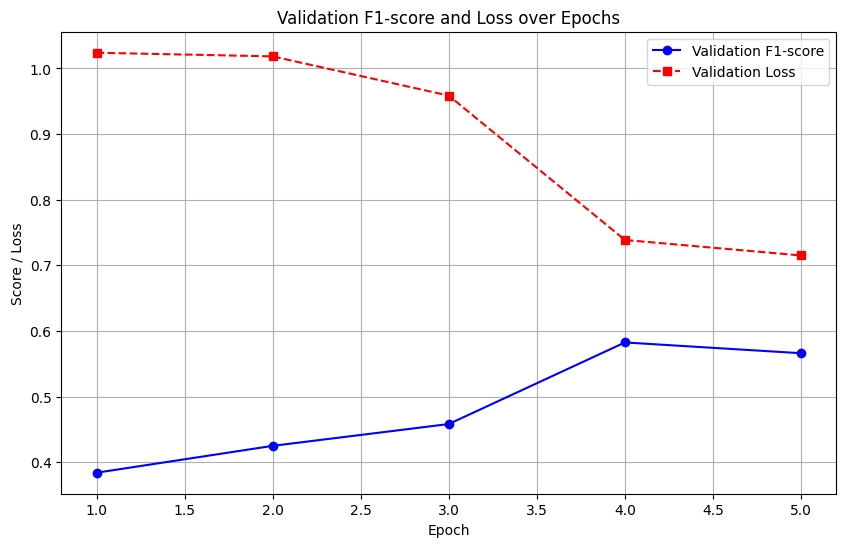

In [91]:
# Plot F1-score and Loss over epochs
f1_scores = history.history['val_f1_score']
val_losses = history.history['val_loss']
epochs = range(1, len(f1_scores) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, f1_scores, marker='o', linestyle='-', color='b', label='Validation F1-score')
plt.plot(epochs, val_losses, marker='s', linestyle='--', color='r', label='Validation Loss')
plt.title('Validation F1-score and Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score / Loss')
plt.legend()
plt.grid(True)
plt.show()

* Validation F1-score (xanh) tăng đều từ epoch 1 đến 4, đạt đỉnh khoảng 0.58, sau đó giảm nhẹ ở epoch 5. Mô hình đang cải thiện nhưng có thể bắt đầu chững lại hoặc bị ảnh hưởng bởi dữ liệu khó.

* Validation Loss (đỏ) giảm từ khoảng 1.03 xuống 0.72, cho thấy mô hình đang tối ưu hóa tốt.

-> Mô hình đang học ổn định, F1-score cải thiện và loss giảm đều. Dao động nhẹ ở cuối quá trình huấn luyện là bình thường. Có thể tiếp tục huấn luyện với 10 - 20 epoch, khi đó nên cân nhắc dùng EarlyStopping theo F1 để dừng khi không cải thiện, áp dụng ReduceLROnPlateau nếu loss chững lại.

In [ ]:
# Load the best model
y_test_pred_proba = model.predict(X_test_padded)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

# Evaluate F1-Score and Classification Report
gru_f1 = f1_score(y_test, y_test_pred, average='macro')

print(f"\nF1 Score: {gru_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step

F1 Score: 0.5750

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.62      0.70      1409
           1       0.14      0.64      0.23       167
           2       0.90      0.72      0.80      1590

    accuracy                           0.67      3166
   macro avg       0.61      0.66      0.58      3166
weighted avg       0.81      0.67      0.72      3166



* Positive (Lớp 2) có F1 = 0.80: mô hình nhận diện rất tốt, với precision 0.90 và recall 0.72.

* Negative (Lớp 0) có F1 = 0.70: hiệu suất khá ổn, nhưng recall thấp hơn 0.62, mô hình còn bỏ sót một số mẫu.

* Neutral (Lớp 1) có F1 = 0.23: mô hình gặp khó khăn lớn, precision chỉ 0.14, dễ nhầm lẫn và bỏ sót nhiều nhãn đúng.

-> Mô hình đạt hiệu suất ở mức trung bình, với F1-score trung bình 0.575. Mô hình hoạt động tốt với positive và negative, nhưng gặp khó khăn rõ rệt với neutral, chủ yếu do số lượng mẫu ít và độ phân biệt thấp. Để cải thiện, có thể tăng dữ liệu cho lớp neutral và cân nhắc sử dụng mô hình mạnh hơn để khai thác ngữ cảnh tốt hơn.

C:\Users\PC\AppData\Local\Temp\ipykernel_32564\2768471225.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='F1_Macro_Score', data=df, palette=['#4c72b0', '#55a868', '#c44e52'])
C:\Users\PC\AppData\Local\Temp\ipykernel_32564\2768471225.py:17: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.barplot(x='Model', y='F1_Macro_Score', data=df, palette=['#4c72b0', '#55a868', '#c44e52'])


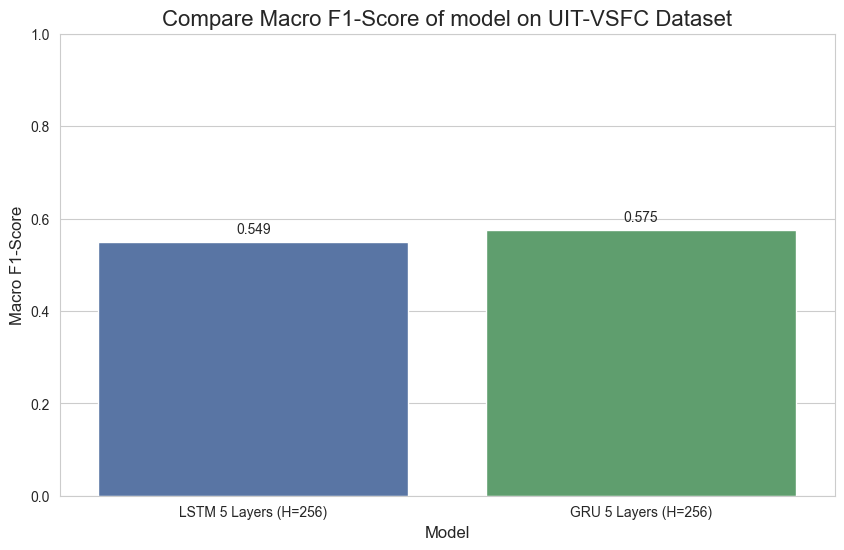

In [93]:
# Data
data = {
    'Model': [
        'LSTM 5 Layers (H=256)', 
        'GRU 5 Layers (H=256)'
    ],
    'F1_Macro_Score': [
        lstm_f1,
        gru_f1,
    ]
}
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x='Model', y='F1_Macro_Score', data=df, palette=['#4c72b0', '#55a868', '#c44e52'])
plt.title('Compare Macro F1-Score of model on UIT-VSFC Dataset', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Macro F1-Score', fontsize=12)
plt.ylim(0.0, 1.0) 

# Annotate bars with F1-Score values
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.show()

* Cả hai mô hình đều có cấu hình giống nhau về số lớp và kích thước ẩn (5 layers, H=256), nhưng GRU cho kết quả tốt hơn.

* Mức chênh lệch F1 tuy không lớn nhưng cho thấy GRU có ưu thế trong bài toán phân loại cảm xúc trên dữ liệu này.

-> GRU vượt trội hơn LSTM nhờ cấu trúc đơn giản với ít tham số, giúp huấn luyện dễ hơn và giảm nguy cơ overfitting, đặc biệt khi dữ liệu không quá lớn. Cơ chế cập nhật trực tiếp giúp GRU giữ lại thông tin quan trọng hiệu quả hơn, đồng thời phản ứng tốt với dữ liệu ngắn hoặc nhiễu. Để cải thiện hiệu suất, có thể thử các biến thể như BiGRU, GRU kết hợp Attention hoặc CNN, và đánh giá độ ổn định bằng cách kiểm tra trên các tập con hoặc áp dụng k-fold cross-validation.